# WeatherService Analytics Notebook

> Read forecasts from MongoDB and display basic graphs for temperature, wind speed, and wind direction.

This notebook connects directly to the same MongoDB used by `WeatherService.Api` and visualizes stored forecasts. No analysis yet—just display.

- Data source: MongoDB database defined in `WeatherService.Api/appsettings.json` (WeatherDb/Forecasts by default).
- Fields displayed: `temperature`, `windSpeed`, `windDirection` (plus timestamp and location).
- Related info shown: units (`temperatureUnit`, `windSpeedUnit`, `windDirectionUnit`), `latitude`, `longitude`, and `sunrise` for context.

## Setup: install dependencies (optional)

You can let the notebook install required packages (similar to Colab). If installs are blocked or you prefer a virtual environment, skip this cell and install manually.

Required packages:
- pandas, numpy
- matplotlib, seaborn
- pymongo
- python-dotenv
- ipykernel

Run this cell to install into the current kernel environment:

%pip install -q --disable-pip-version-check --no-input pandas numpy matplotlib seaborn pymongo python-dotenv ipykernel

In [10]:
# Install dependencies into this kernel (optional)
import sys
print(sys.executable)  # show current kernel Python
%pip install -q --disable-pip-version-check pandas numpy matplotlib seaborn pymongo python-dotenv

/home/dontloseyourheadsu/Documents/GitHub/WeatherService/.venv/bin/python


Note: you may need to restart the kernel to use updated packages.


In [11]:
# If you skipped the install cell above, ensure these imports are available.
import os, json, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from datetime import datetime
from pathlib import Path

In [12]:
# Load MongoDB connection settings from WeatherService.Api/appsettings.json, with env overrides.
api_appsettings = Path('..') / 'WeatherService.Api' / 'appsettings.json'
cfg = {}
if api_appsettings.exists():
    with open(api_appsettings, 'r') as f:
        cfg = json.load(f)
else:
    print(f"Warning: {api_appsettings} not found. Falling back to environment variables only.")

mongo_uri = os.getenv('MONGODB_URI') or cfg.get('MongoDb', {}).get('ConnectionUri', 'mongodb://localhost:27017')
mongo_db  = os.getenv('MONGODB_DB') or cfg.get('MongoDb', {}).get('DatabaseName', 'WeatherDb')
mongo_col = os.getenv('MONGODB_COLLECTION') or cfg.get('MongoDb', {}).get('Collections', {}).get('Forecasts', 'Forecasts')

print('Using MongoDB settings:')
print(' - URI        :', mongo_uri)
print(' - Database   :', mongo_db)
print(' - Collection :', mongo_col)

Using MongoDB settings:
 - URI        : mongodb://localhost:27017
 - Database   : WeatherDb
 - Collection : Forecasts


In [13]:
# Connect to MongoDB and load documents into a pandas DataFrame
client = MongoClient(mongo_uri)
db = client[mongo_db]
collection = db[mongo_col]

# Pull documents; limit/skip can be added if dataset is huge
cursor = collection.find({}, {
    '_id': 0,
    'timestamp': 1,
    'latitude': 1,
    'longitude': 1,
    'temperature': 1,
    'temperatureUnit': 1,
    'windSpeed': 1,
    'windSpeedUnit': 1,
    'windDirection': 1,
    'windDirectionUnit': 1,
    'sunrise': 1,
})

docs = list(cursor)
if not docs:
    print('No documents found in collection.')

df = pd.DataFrame(docs)

# Convert types
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
if 'sunrise' in df.columns:
    df['sunrise'] = pd.to_datetime(df['sunrise'])

# Robust location label (handles str/float and missing values)
def _fmt_loc(lat, lon):
    try:
        return f"({float(lat):.4f}, {float(lon):.4f})"
    except (TypeError, ValueError):
        return 'unknown'

if 'latitude' in df.columns and 'longitude' in df.columns:
    df['location'] = df.apply(lambda r: _fmt_loc(r.get('latitude'), r.get('longitude')), axis=1)
else:
    df['location'] = 'unknown'

# Sort by location then time for stable plotting
if {'location', 'timestamp'}.issubset(df.columns):
    df = df.sort_values(['location', 'timestamp'])

# Quick glance
display(df.head())
print('\nRows:', len(df))
print('Columns:', list(df.columns))

,timestamp,latitude,longitude,temperature,temperatureUnit,windSpeed,windSpeedUnit,windDirection,windDirectionUnit,sunrise,location
1,2025-10-23 18:00:00,18.833333,-98.0000,23.6,°C,10.8,km/h,88,°,2025-10-23 12:28:00,"(18.8333, -98.0000)"
0,2025-10-23 18:00:00,19.000000,-98.0000,19.2,°C,13.5,km/h,74,°,2025-10-23 12:28:00,"(19.0000, -98.0000)"
2,2025-10-23 19:00:00,19.076600,-98.3021,23.7,°C,6.7,km/h,36,°,2025-10-23 12:30:00,"(19.0766, -98.3021)"



Rows: 3
Columns: ['timestamp', 'latitude', 'longitude', 'temperature', 'temperatureUnit', 'windSpeed', 'windSpeedUnit', 'windDirection', 'windDirectionUnit', 'sunrise', 'location']


In [14]:
# Configure plotting style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

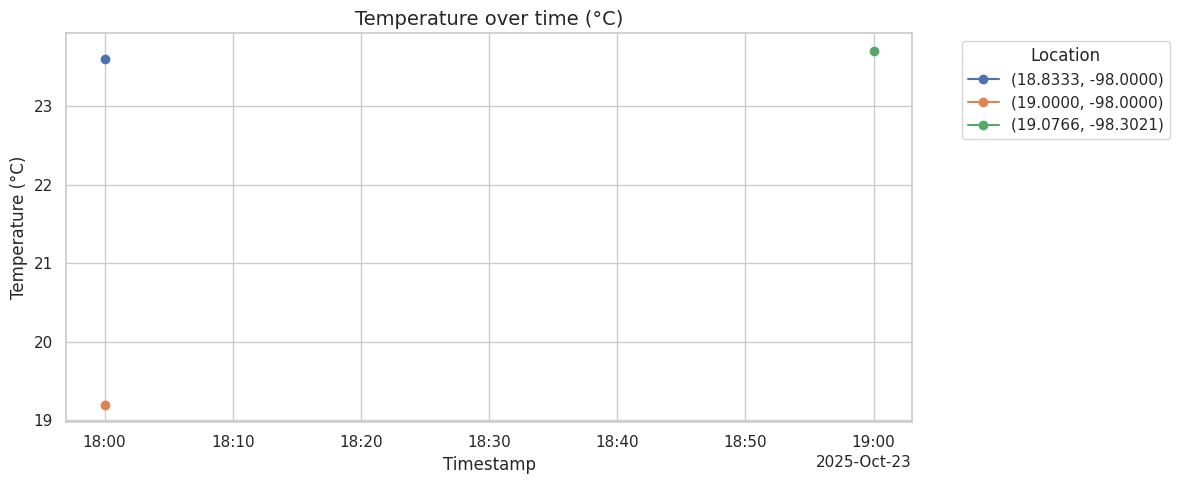

In [15]:
## Temperature over time
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

if 'temperature' in df.columns and 'timestamp' in df.columns:
    fig, ax = plt.subplots()
    for loc, g in df.groupby('location'):
        g = g.sort_values('timestamp')
        ax.plot(g['timestamp'], g['temperature'], marker='o', linewidth=1.5, label=loc)
    unit = df['temperatureUnit'].dropna().iloc[0] if 'temperatureUnit' in df.columns and df['temperatureUnit'].notna().any() else ''
    ax.set_title(f'Temperature over time {f"({unit})" if unit else ""}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Temperature' + (f' ({unit})' if unit else ''))
    locator = AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))
    ax.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print('temperature/timestamp not found in data')

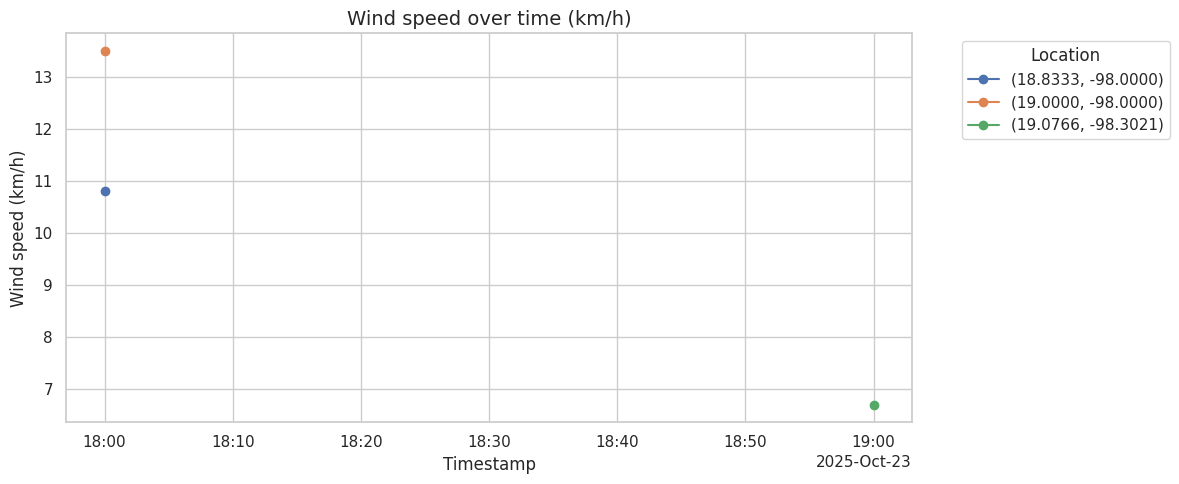

In [16]:
## Wind speed over time
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

if 'windSpeed' in df.columns and 'timestamp' in df.columns:
    fig, ax = plt.subplots()
    for loc, g in df.groupby('location'):
        g = g.sort_values('timestamp')
        ax.plot(g['timestamp'], g['windSpeed'], marker='o', linewidth=1.5, label=loc)
    unit = df['windSpeedUnit'].dropna().iloc[0] if 'windSpeedUnit' in df.columns and df['windSpeedUnit'].notna().any() else ''
    ax.set_title(f'Wind speed over time {f"({unit})" if unit else ""}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Wind speed' + (f' ({unit})' if unit else ''))
    locator = AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))
    ax.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print('windSpeed/timestamp not found in data')

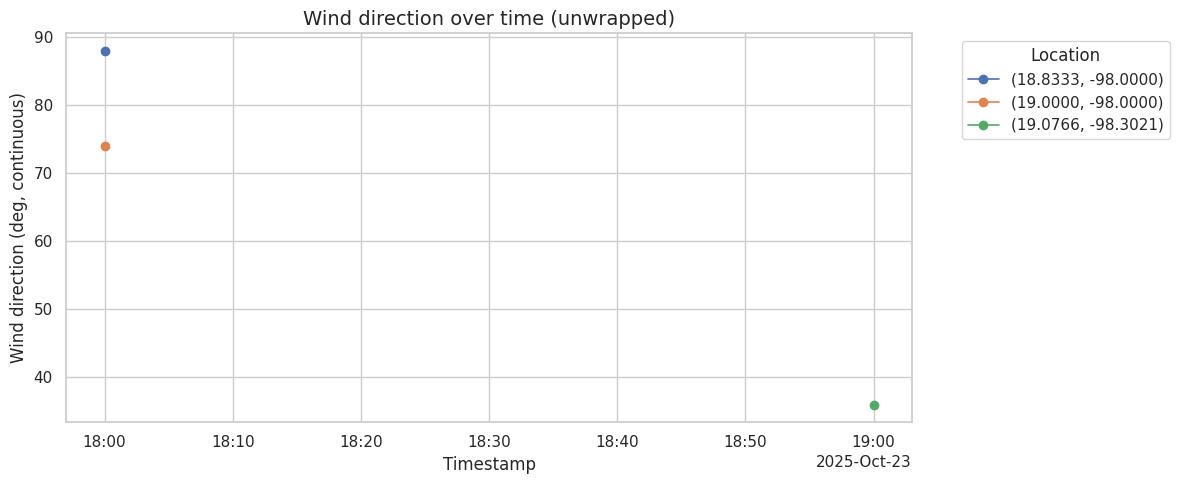

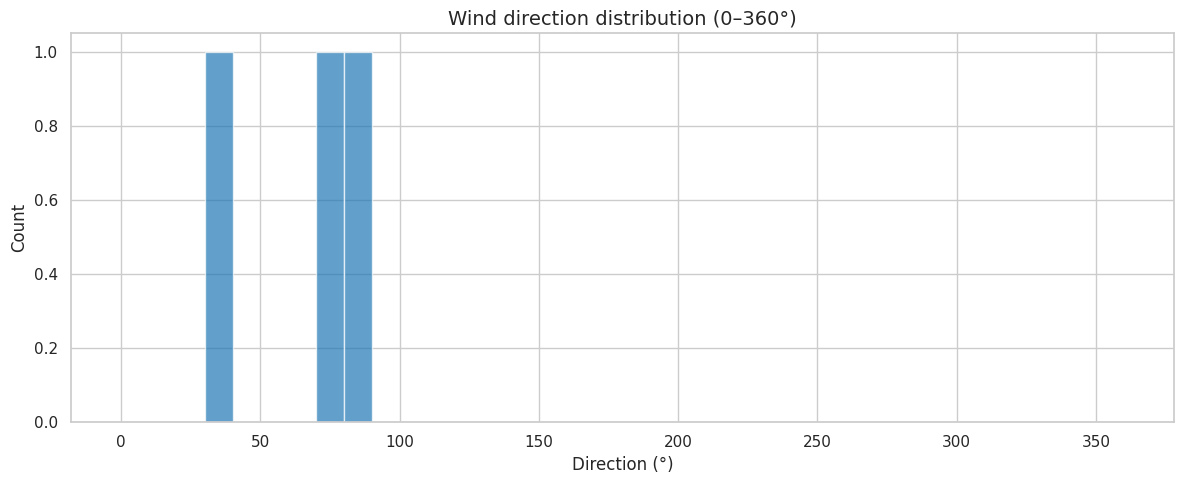

In [17]:
## Wind direction over time and distribution (handle circular wrap)
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

def _unwrap_degrees(series):
    # Convert to radians, unwrap phase to avoid 360->0 jumps, then back to degrees
    rad = np.deg2rad(series.astype(float).to_numpy())
    unwrapped = np.unwrap(rad)
    return np.rad2deg(unwrapped)

if 'windDirection' in df.columns and 'timestamp' in df.columns:
    # Continuous time-series plot per location
    fig, ax = plt.subplots()
    for loc, g in df.groupby('location'):
        g = g.sort_values('timestamp')
        y = _unwrap_degrees(g['windDirection'].dropna())
        ax.plot(g.loc[g['windDirection'].notna(), 'timestamp'], y, marker='o', linewidth=1.2, label=loc)
    unit = df['windDirectionUnit'].dropna().iloc[0] if 'windDirectionUnit' in df.columns and df['windDirectionUnit'].notna().any() else '°'
    ax.set_title(f'Wind direction over time (unwrapped)')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(f'Wind direction (deg, continuous)')
    locator = AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))
    ax.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Histogram on 0-360° using original values
    fig, ax = plt.subplots()
    vals = df['windDirection'].dropna().astype(float) % 360
    ax.hist(vals, bins=36, range=(0, 360), color='tab:blue', alpha=0.7)
    ax.set_title('Wind direction distribution (0–360°)')
    ax.set_xlabel('Direction (°)')
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('windDirection/timestamp not found in data')

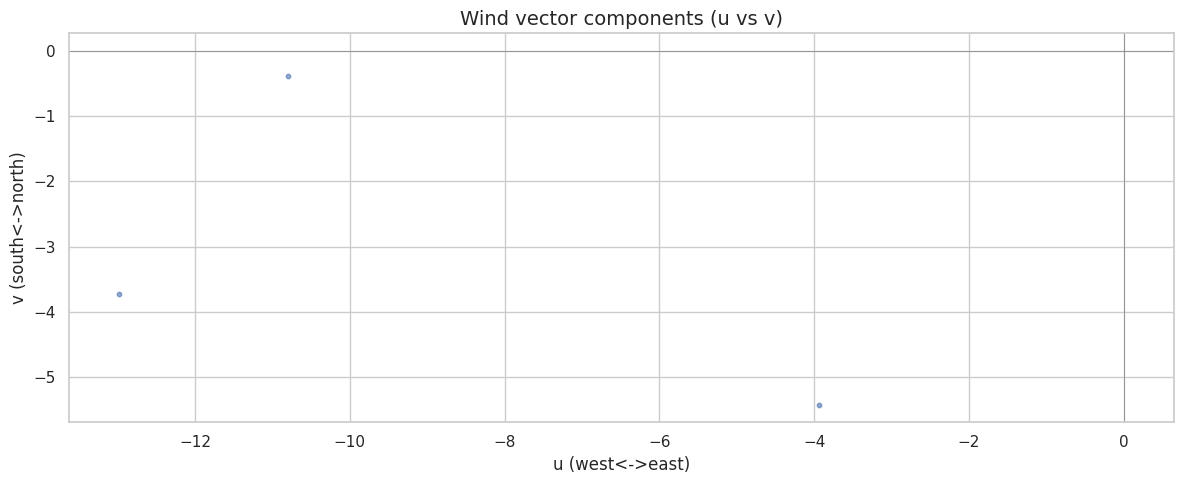

In [18]:
## Optional: derive wind vector components for display (no analysis)
if 'windSpeed' in df.columns and 'windDirection' in df.columns:
    # Convert degrees to radians and compute u (east-west), v (north-south) components
    rad = np.deg2rad(df['windDirection'])
    df['wind_u'] = -df['windSpeed'] * np.sin(rad)  # meteorological convention
    df['wind_v'] = -df['windSpeed'] * np.cos(rad)

    fig, ax = plt.subplots()
    ax.scatter(df['wind_u'], df['wind_v'], s=10, alpha=0.6)
    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)
    ax.set_title('Wind vector components (u vs v)')
    ax.set_xlabel('u (west<->east)')
    ax.set_ylabel('v (south<->north)')
    plt.tight_layout()
    plt.show()
else:
    print('windSpeed/windDirection not found for vector display')